<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/IEGWResNet/ONDATA2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import keras
from keras.layers import Conv2D, Activation, Input, Dropout, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, multiply, Add, LeakyReLU, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import *
from keras import regularizers
from keras import backend as K
from keras.models import load_model
from keras.layers import Lambda
import nibabel as nib

Using TensorFlow backend.


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 51 kB/s 


In [ ]:
import SimpleITK as sitk

In [ ]:
flair_path = glob.glob('/content/drive/MyDrive/ranadeep/2021DATA/data/'+'*/*_flair*', recursive=True)
seg_path = glob.glob('/content/drive/MyDrive/ranadeep/2021DATA/data/'+'*/*_seg*', recursive=True)
t1_path = glob.glob('/content/drive/MyDrive/ranadeep/2021DATA/data/'+'*/*_t1*', recursive=True)
t1ce_path = glob.glob('/content/drive/MyDrive/ranadeep/2021DATA/data/'+'*/*_t1ce*', recursive=True)
t2_path = glob.glob('/content/drive/MyDrive/ranadeep/2021DATA/data/'+'*/*_t2*', recursive=True)

In [ ]:
print(len(flair_path))

1251


In [ ]:
def pca_color_augmentation_tensor(inputs, std_deviation=0.1, scale=0.1, clipping=False):
    ranks = inputs.ndim
    assert ranks >= 2

    chs = inputs.shape[-1]
    if ranks <= 3:
        x = inputs.copy()
    elif ranks == 4:
        dims = inputs.shape[1] * inputs.shape[2]
        x = inputs.reshape(-1, dims, chs)
    elif ranks == 5:
        dims = inputs.shape[2] * inputs.shape[3]
        depth = inputs.shape[1]
        x = inputs.reshape(-1, depth, dims, chs)
    calculate_axis, reduce_axis = ranks-1, ranks-2
    if ranks == 3:
        calculate_axis, reduce_axis = 1, 2
    elif ranks >= 4:
        calculate_axis, reduce_axis = ranks-3, ranks-2
    C = 1.0
    if ranks >= 3:
        C = x.shape[reduce_axis]
    var = np.var(x, axis=calculate_axis, keepdims=True)
    scaling_factors = np.sqrt(C / np.sum(var, axis=reduce_axis, keepdims=True))
    x = x * scaling_factors
    # subtract mean for cov matrix
    mean = np.mean(x, axis=calculate_axis, keepdims=True)
    x -= mean
    # covariance matrix
    cov_n = max(x.shape[calculate_axis] - 1, 1)
    # cov (since x was normalized)
    cov = np.matmul(np.swapaxes(x, -1, -2), x) / cov_n
    # eigen value(S), eigen vector(U)
    U, S, V = np.linalg.svd(cov)
    if ranks == 2:
        rand = np.random.randn(*inputs.shape) * std_deviation
        delta = np.matmul(rand*np.expand_dims(S, axis=0), U)
    else:
        rand = np.random.randn(*S.shape) * std_deviation
        delta_original = np.squeeze(np.matmul(U, np.expand_dims(rand*S, axis=-1)), axis=-1)
    if ranks == 3:
        delta = np.expand_dims(delta_original, axis=ranks-2)
    elif ranks >= 4:
        delta = np.expand_dims(delta_original, axis=ranks-3)
        delta = np.broadcast_to(delta, x.shape)
        delta = delta.reshape(-1, *inputs.shape[1:])

    # delta scaling
    delta = delta * scale
    result = inputs + delta
    if clipping:
        result = np.clip(result, 0.0, scale)

    return result

In [ ]:
X_flair=[]
for i in range(50):
    a = sitk.ReadImage(flair_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_flair.append((a[50+2*j,:,:]))
print(np.shape(X_flair))

(1250, 240, 240)


In [ ]:
X_flair = np.asarray(X_flair).astype(np.float32)

In [ ]:
X_flair = pca_color_augmentation_tensor(X_flair[:,:,:])

In [ ]:
mean = X_flair.mean()
std = X_flair.std()
X_flair = (X_flair - mean)/(std + 1e-8)
np.min(X_flair), np.max(X_flair)

(-0.5488258567292074, 14.116275750258662)

In [ ]:
X_t1=[]
for i in range(50):
    a = sitk.ReadImage(t1_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t1.append((a[50+2*j,:,:]))
print(np.shape(X_t1))

(1250, 240, 240)


In [ ]:
X_t1 = np.asarray(X_t1).astype(np.float32)
X_t1 = pca_color_augmentation_tensor(X_t1[:,:,:])

In [ ]:
mean = X_t1.mean()
std = X_t1.std()
X_t1 = (X_t1 - mean)/(std + 1e-8)
np.min(X_t1), np.max(X_t1)

(-0.5911301173754586, 13.280509606200344)

In [ ]:
X_t1ce=[]
for i in range(50):
    a = sitk.ReadImage(t1ce_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t1ce.append((a[50+2*j,:,:]))
print(np.shape(X_t1ce))

(1250, 240, 240)


In [ ]:
X_t1ce = np.asarray(X_t1ce).astype(np.float32)
X_t1ce = pca_color_augmentation_tensor(X_t1ce[:,:,:])

In [ ]:
mean = X_t1ce.mean()
std = X_t1ce.std()
X_t1ce = (X_t1ce - mean)/(std + 1e-8)
np.min(X_t1ce), np.max(X_t1ce)

(-0.5856471384379387, 12.348360302074795)

In [ ]:
X_t2=[]
for i in range(50):
    a = sitk.ReadImage(t2_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t2.append((a[50+2*j,:,:]))
print(np.shape(X_t2))

(1250, 240, 240)


In [ ]:
X_t2 = np.asarray(X_t2).astype(np.float32)
X_t2 = pca_color_augmentation_tensor(X_t2[:,:,:])

In [ ]:
mean = X_t2.mean()
std = X_t2.std()
X_t2 = (X_t2 - mean)/(std + 1e-8)
np.min(X_t2), np.max(X_t2)

(-0.5292939487317605, 10.762808438391946)

In [ ]:
X_seg=[]
for i in range(50):
    a = sitk.ReadImage(seg_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_seg.append((a[50+2*j,:,:]))
print(np.shape(X_seg))

(1250, 240, 240)


In [ ]:
X_seg = np.asarray(X_seg).astype(np.float32)


In [ ]:
print(X_flair.shape[0])

1250


In [ ]:
data = np.zeros((X_flair.shape[0],240,240,4))
for i in range(data.shape[0]):
    data[i,:,:,0] = X_flair[i,:,:]
    data[i,:,:,1] = X_t1[i,:,:]
    data[i,:,:,2] = X_t1ce[i,:,:]
    data[i,:,:,3] = X_t2[i,:,:]

In [ ]:
print(np.shape(data))

(1250, 240, 240, 4)


In [ ]:
del X_flair
del X_t1
del X_t2
del X_t1ce

In [ ]:
print(np.unique(X_seg))

[0. 1. 2. 4.]


In [ ]:
X_seg[X_seg == 4] = 3

In [ ]:
print(np.unique(X_seg))

[0. 1. 2. 3.]


In [ ]:
print(X_seg.shape)

(1250, 240, 240)


In [ ]:
from tensorflow.keras.utils import to_categorical
gt = to_categorical(X_seg, num_classes=None)
print(gt.shape)

(1250, 240, 240, 4)


In [ ]:
print(data.shape)
print(gt.shape)

(1250, 240, 240, 4)
(1250, 240, 240, 4)


In [ ]:
del X_seg

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.30, random_state=42)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(875, 240, 240, 4)
(375, 240, 240, 4)


In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(875, 240, 240, 4)
(375, 240, 240, 4)


# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_datagen = ImageDataGenerator(rotation_range=5,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)
mask_datagen = ImageDataGenerator(rotation_range=5,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)

In [ ]:
image_generator = image_datagen.flow(X_train, batch_size=8, seed=1)

mask_generator = mask_datagen.flow(Y_train, batch_size=8, seed=1)

In [ ]:
def train_generator(image_generator, mask_generator):
    while True:
        image_next = image_generator.next()
        mask_next  = mask_generator.next()
        yield image_next, [mask_next, mask_next, mask_next, mask_next]

In [ ]:
from scipy.stats import pearsonr
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Activation, UpSampling2D, multiply
from tensorflow.keras import regularizers
def ieg_block2d(x, g, ch_inp, i, data_format='channels_last'):
    reg = regularizers.l2(1e-5)
    def conv_bn(x, filters, kernel_size, strides, dilation_rate=1):
        x = Conv2D(filters, kernel_size, strides=strides, dilation_rate=dilation_rate,
                   data_format=data_format, kernel_regularizer=reg)(x)
        x = BatchNormalization()(x)
        return x
    x1 = conv_bn(x, ch_inp, [2, 2], strides=[2, 2])
    x2 = conv_bn(g, ch_inp, [1, 1], strides=[1, 1], dilation_rate=i)
    f = LeakyReLU(alpha=0.001)(Add()([x1, x2]))
    x3 = conv_bn(f, 1, [1, 1], strides=[1, 1], dilation_rate=i)
    x4 = Activation('sigmoid')(x3)
    x5 = UpSampling2D(size=[2, 2])(x4)
    att_x = multiply([x, x5])
    return att_x

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, MaxPooling2D
from tensorflow.keras import regularizers

def res_block(x, nb_filters, strides, i):
    reg = regularizers.l2(1e-5)
    def conv_bn_relu(x, filters, kernel_size, strides=1, dilation_rate=1, padding='same'):
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, dilation_rate=dilation_rate,
                   padding=padding, kernel_regularizer=reg)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.001)(x)
        return x
    # Initial batch normalization and pooling
    res_inp = BatchNormalization()(x)
    res_inp = LeakyReLU(alpha=0.001)(res_inp)
    pool = MaxPooling2D(pool_size=(2, 2))(res_inp)
    # conv-BN-ReLU
    res_inp = conv_bn_relu(pool, nb_filters[0], (3, 3), strides=strides[1], dilation_rate=i)
    res_inp = conv_bn_relu(res_inp, nb_filters[1], (3, 3), strides=strides[1], dilation_rate=i)
    shortcut = Conv2D(nb_filters[1], (1, 1), strides=strides[1], dilation_rate=i, padding='same',
                      kernel_regularizer=reg)(pool)
    shortcut = BatchNormalization()(shortcut)
    res_inp = Add()([shortcut, res_inp])
    return res_inp


In [ ]:
def contraction(x):
    to_expansion = []

    con_inp = Conv2D(filters=64, kernel_size=(3, 3), padding='same',dilation_rate=(1,1), strides=(1, 1), kernel_regularizer=regularizers.l2(1e-5))(x)
    con_inp = BatchNormalization()(con_inp)
    con_inp = LeakyReLU(alpha=0.001)(con_inp)

    con_inp = Conv2D(filters=64, kernel_size=(3, 3), padding='same',dilation_rate=(1,1),strides=(1, 1), kernel_regularizer=regularizers.l2(1e-5))(con_inp)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1),dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5))(x)
    shortcut = BatchNormalization()(shortcut)

    con_inp = Add()([shortcut, con_inp])

    # first branching to expansion
    to_expansion.append(con_inp)

    con_inp = res_block(con_inp, [128, 128], [(2, 2), (1, 1)],(1,1))
    to_expansion.append(con_inp)

    con_inp = res_block(con_inp, [256, 256], [(2, 2), (1, 1)],(2,2))
    to_expansion.append(con_inp)

    con_inp = res_block(con_inp, [512, 512], [(2, 2), (1, 1)],(4,4))
    to_expansion.append(con_inp)

    return to_expansion

In [ ]:
def res_block_expansion(x, nb_filters, strides,i):

    res_path = BatchNormalization()(x)
    res_path = LeakyReLU(alpha=0.001)(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = LeakyReLU(alpha=0.001)(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[1], dilation_rate=i, kernel_regularizer=regularizers.l2(1e-5))(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = Add()([shortcut, res_path])

    return res_path


In [ ]:
def expansion(x, from_contraction):

    # Layer 4
    ieg_path1 = ieg_block2d(from_contraction[3], x, 256, (1,1), data_format='channels_last')

    exp_inp1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5))(x)
    exp_inp1 = Concatenate()([exp_inp1,ieg_path1])
    exp_inp1 = res_block_expansion(exp_inp1, [512, 512], [(1, 1), (1, 1)],(4,4))

    hc1 = trans_conv_operation(exp_inp1)
    out_1 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_1')(hc1)


    # Layer 3
    ieg_path2 = ieg_block2d(from_contraction[2],exp_inp1 ,128,(1,1),data_format='channels_last')

    exp_inp2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), dilation_rate=(1,1), padding='same', kernel_regularizer=regularizers.l2(1e-5))(exp_inp1)
    exp_inp2 = Concatenate()([exp_inp2,ieg_path2])
    exp_inp2 = res_block_expansion(exp_inp2, [256, 256], [(1, 1), (1, 1)],(2,2))

    hc2 = trans_conv_operation_two(exp_inp2)
    out_2 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_2')(hc2)


    # Layer 2
    ieg_path3 = ieg_block2d(from_contraction[1],exp_inp2,64,(1,1),data_format='channels_last')

    exp_inp3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (exp_inp2)
    exp_inp3 = Concatenate()([exp_inp3,ieg_path3])
    exp_inp3 = res_block_expansion(exp_inp3, [128, 128], [(1, 1), (1, 1)],(1,1))

    hc3 = trans_conv_operation_one(exp_inp3)
    out_3 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_3')(hc3)


    # Layer 1
    ieg_path4 = ieg_block2d(from_contraction[0],exp_inp3,32,(1,1),data_format='channels_last')

    exp_inp4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5)) (exp_inp3)
    exp_inp4 = Concatenate()([exp_inp4,ieg_path4])
    exp_inp4 = res_block_expansion(exp_inp4, [64, 64], [(1, 1), (1, 1)],(1,1))

    return exp_inp4, out_3, out_2, out_1

In [ ]:
def trans_conv_operation(input_val):
    tran_x1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5)) (input_val)
    tran_x2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (tran_x1)
    tran_x3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (tran_x2)
    return tran_x3
def trans_conv_operation_two(input_val):
    tran_x1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5))(input_val)
    tran_x2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1) ,kernel_regularizer=regularizers.l2(1e-5))(tran_x1)
    return tran_x2
def trans_conv_operation_one(input_val):
    tran_x1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (input_val)
    return tran_x1

In [ ]:
def hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    to_expansion = contraction(inputs)

    path = res_block(to_expansion[3], [1024, 1024], [(2, 2), (1, 1)],(8,8))

    final_out, out_3, out_2, out_1 = expansion(path, from_contraction=to_expansion)

    final_out = Conv2D(filters=4, kernel_size=(1, 1), activation='sigmoid', name='final_output')(final_out)

    return Model(inputs=inputs, outputs= [final_out, out_3, out_2, out_1])

In [ ]:
def dice_coef_0(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_1(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_2(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_3(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,3])
    y_pred_f = K.flatten(y_pred[:,:,:,3])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def dice_score(y_true, y_pred):
    d0 = dice_coef_0(y_true, y_pred,smooth=0.000001)
    d1 = dice_coef_1(y_true, y_pred,smooth=0.000001)
    d2 = dice_coef_2(y_true, y_pred,smooth=0.000001)
    d3 = dice_coef_3(y_true, y_pred,smooth=0.000001)

    dice_mean = (d0+d1+d2+d3)/4
    return dice_mean

def weighted_dice_score(y_true, y_pred):
    ds0 = dice_coef_0(y_true, y_pred,smooth=0.000001)
    ds1 = dice_coef_1(y_true, y_pred,smooth=0.000001)
    ds2 = dice_coef_2(y_true, y_pred,smooth=0.000001)
    ds3 = dice_coef_3(y_true, y_pred,smooth=0.000001)
    weighted_dice_mean = (ds0+(5*ds1)+(2*ds2)+(4*ds3))/12
    return weighted_dice_mean

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2

In [ ]:
def dice_loss(y_true, y_pred):
    return 1-dice_score(y_true, y_pred)
def weighted_dice_loss(y_true, y_pred):
    return 1-weighted_dice_score(y_true, y_pred)

In [ ]:
import tensorflow as tf
def weighted_log_loss(y_true, y_pred):
    y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    weights = tf.constant([1, 5, 2, 4], dtype=tf.float32)
    loss = y_true * tf.math.log(y_pred) * weights
    loss = tf.reduce_mean(-tf.reduce_sum(loss, -1))
    return loss


In [ ]:
def corr_dice_loss(y_true, y_pred):
    return weighted_dice_loss(y_true, y_pred)+weighted_log_loss(y_true,y_pred)+correlation_coefficient_loss(y_true,y_pred)

In [ ]:
input_shape = (240,240,4)
losses = {
    'final_output':corr_dice_loss,
    'out_3':corr_dice_loss,
    'out_2':corr_dice_loss,
    'out_1':corr_dice_loss,
}
lossWeights = {"final_output": 0.5, "out_3": 0.125, "out_2": 0.125, "out_1": 0.125}

In [ ]:
batch_size = 64
image_size = 240
epochs = 100

In [ ]:
model = hybrid_at_onet(input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001), loss= losses,
              metrics=['accuracy',dice_score,precision, sensitivity, specificity])

In [ ]:
history=model.fit(train_generator(input_gen, out_gen),
	                  validation_data=(X_test, [Y_test, Y_test, Y_test, Y_test]),
	                  steps_per_epoch=len(X_train) // 64,
	                  epochs=epochs, verbose=1, shuffle=True,
                    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
13/13 [==============================] - 53s 4s/step - loss: 11.1914 - final_output_loss: 2.8498 - out_3_loss: 2.7307 - out_2_loss: 2.7204 - out_1_loss: 2.7735 - final_output_accuracy: 0.6706 - final_output_dice_score: 0.2201 - final_output_precision: 0.4718 - final_output_sensitivity: 0.7789 - final_output_specificity: 0.7227 - out_3_accuracy: 0.8069 - out_3_dice_score: 0.1977 - out_3_precision: 0.8077 - out_3_sensitivity: 0.5866 - out_3_specificity: 0.9793 - out_2_accuracy: 0.7805 - out_2_dice_score: 0.1885 - out_2_precision: 0.8481 - out_2_sensitivity: 0.5454 - out_2_specificity: 0.9902 - out_1_accuracy: 0.7931 - out_1_dice_score: 0.1777 - out_1_precision: 0.8310 - out_1_sensitivity: 0.4610 - out_1_specificity: 0.9959 - val_loss: 12.8851 - val_final_output_loss: 3.2509 - val_out_3_loss: 3.1632 - val_out_2_loss: 3.1800 - val_out_1_loss: 3.1736 - val_final_output_accuracy: 0.7189

In [ ]:
#model.save('/content/drive/MyDrive/ranadeep/2021DATA/model.h5', include_optimizer=True)

In [ ]:
def Accuracy_Graph(history):
    plt.plot(history.history['final_output_accuracy'])
    plt.plot(history.history['val_final_output_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()


# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['final_output_dice_score'])
    plt.plot(history.history['val_final_output_dice_score'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

def Loss_Graph(history):
    plt.plot(history.history['final_output_loss'])
    plt.plot(history.history['val_final_output_loss'])
    #plt.title('Model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()



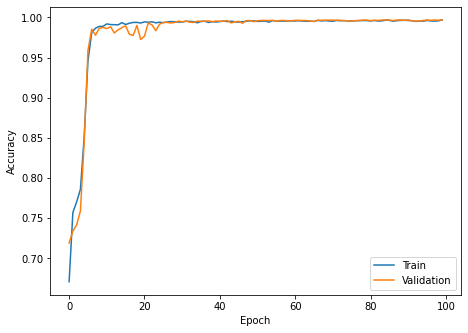

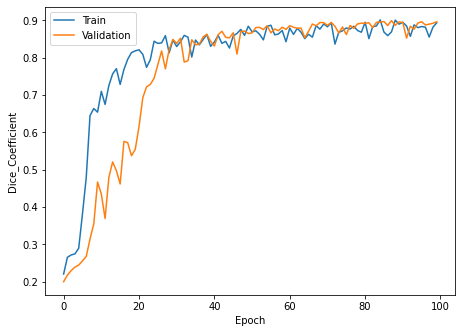

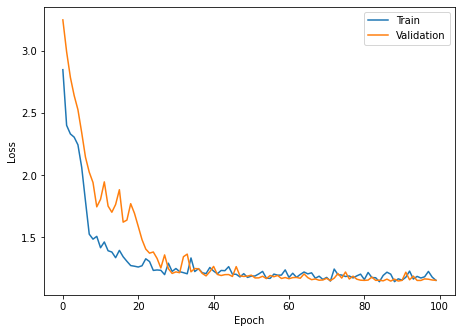

In [ ]:
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
import statistics
display(statistics.mean(history.history['val_final_output_accuracy']))
display(statistics.mean(history.history['val_final_output_dice_score']))
display(statistics.mean(history.history['val_final_output_precision']))
display(statistics.mean(history.history['val_final_output_sensitivity']))
display(statistics.mean(history.history['val_final_output_specificity']))

0.9813938331604004

0.7638620775938034

0.9724263319373131

0.9862463754415512

0.9855877012014389

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(np.shape(pred))

(4, 375, 240, 240, 4)


In [ ]:
pred = np.argmax(pred, axis=-1)

In [ ]:

predicted_images = np.reshape(pred[0,:,:,:], (375,240,240))

In [ ]:
GT = np.argmax(Y_test, axis=-1)
print(GT.shape)

(375, 240, 240)


In [ ]:
predicted_images[predicted_images==3] = 4
GT[GT==3] = 4

In [ ]:
def iou_coef(s,g):
    num = np.sum(np.multiply(s,g))
    denom=s.sum() + g.sum() - num
    if denom==0:
        return 1
    else:
        return num/denom

In [ ]:
def iou_whole(pred, orig_label):
    #computes dice for the whole tumor
    return iou_coef(pred>0,orig_label>0)


def iou_en(pred, orig_label):
    #computes dice for enhancing region
    return iou_coef(pred==4,orig_label==4)


def iou_core(pred, orig_label):
    #computes dice for core region
    seg_=np.copy(pred)
    ground_=np.copy(orig_label)
    seg_[seg_==2]=0
    ground_[ground_==2]=0
    return iou_coef(seg_>0,ground_>0)

In [ ]:
predicted_images = predicted_images.astype(np.int32)
GT = GT.astype(np.int32)

iou_complete  = iou_whole(predicted_images,GT)
iou_enhancing = iou_en(predicted_images,GT)
iou_core      = iou_core(predicted_images,GT)

print("iou complete tumor score : {:0.4f}".format(iou_complete))
print("iou core tumor score : {:0.4f}".format(iou_core))
print("iou enhancing tumor score :{:0.4f} ".format(iou_enhancing))

iou complete tumor score : 0.8883
iou core tumor score : 0.9045
iou enhancing tumor score :0.8188 


In [ ]:


def binary_dice3d(s,g):
    #dice score of two 3D volumes
    num=np.sum(np.multiply(s, g))
    denom=s.sum() + g.sum()
    if denom==0:
        return 1
    else:
        return  2.0*num/denom



def DSC_whole(pred, orig_label):
    #computes dice for the whole tumor
    return binary_dice3d(pred>0,orig_label>0)


def DSC_en(pred, orig_label):
    #computes dice for enhancing region
    return binary_dice3d(pred==4,orig_label==4)


def DSC_core(pred, orig_label):
    #computes dice for core region
    seg_=np.copy(pred)
    ground_=np.copy(orig_label)
    seg_[seg_==2]=0
    ground_[ground_==2]=0
    return binary_dice3d(seg_>0,ground_>0)

In [ ]:
Dice_complete=DSC_whole(predicted_images,GT)
Dice_enhancing=DSC_en(predicted_images,GT)
Dice_core=DSC_core(predicted_images,GT)

print("Dice complete tumor score : {:0.4f}".format(Dice_complete))
print("Dice core tumor score : {:0.4f}".format(Dice_core))
print("Dice enhancing tumor score :{:0.4f} ".format(Dice_enhancing))

Dice complete tumor score : 0.9408
Dice core tumor score : 0.9499
Dice enhancing tumor score :0.9004 
